In [66]:
!mkdir -p ~/.kaggle
!touch ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!echo '{"username":"YOUR-USERNAME","key":"YOUR-API-KEY"}' > ~/.kaggle/kaggle.json

In [67]:
!kaggle datasets download -d kartik2112/fraud-detection

fraud-detection.zip: Skipping, found more recently modified local copy (use --force to force download)


In [68]:
!unzip -o fraud-detection.zip

Archive:  fraud-detection.zip
  inflating: fraudTest.csv           
  inflating: fraudTrain.csv          


In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [70]:
train_master = pd.read_csv('fraudTrain.csv', index_col=0)
test_master = pd.read_csv('fraudTest.csv', index_col=0)

In [71]:
# Source: https://stackoverflow.com/a/29546836/6948907

def haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)
    All args must be of equal length.    

    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

def is_weekend(txn_time):
    return int(txn_time.weekday() >= 5)

def is_night(txn_time):
    return int(txn_time.hour <= 6 or txn_time.hour >= 22)

In [72]:
def get_txn_history(txns, windows=[7, 15, 30, 60]):
    txns = txns.sort_values('trans_date_trans_time')
    txns.index = txns.trans_date_trans_time
    
    for window in windows:
        total_amt = txns['amt'].rolling(window, min_periods = 1).sum()
        count_amt = txns['amt'].rolling(window, min_periods = 1).count()

        avg_amt = total_amt/count_amt

        txns[f'count_amt_{window}_days'] = list(count_amt)
        txns[f'count_avg_{window}_days'] = list(avg_amt)

    txns.reset_index(drop = True)
    return txns

In [73]:
def transform(df):
    df = df.groupby('cc_num').apply(lambda x: get_txn_history(x, windows=[7, 15, 30]))
    df.reset_index(drop=True, inplace = True)
    df = df.sort_values('trans_date_trans_time')

    # Fraud by merchant
    fraud_by_merch = df[(df['is_fraud'] == 1)].groupby('merchant')['merchant'].count().to_dict()
    df['fraud_by_merch'] = df['merchant'].transform(lambda m: fraud_by_merch.get(m, 0))

    # Retain only month and year of txn
    df['trans_month'] = pd.DatetimeIndex(df['trans_date_trans_time']).month
    df['trans_year'] = pd.DatetimeIndex(df['trans_date_trans_time']).year

    # Calculate distance between user and merchant
    df['distance_bet_user_merchant'] = haversine_np(
        df['lat'], df['long'],
        df['merch_lat'], df['merch_long']
    )

    # Encode gender
    df['gender'] = df['gender'].transform(lambda g: 1 if g == 'F' else 0)

    # One hot encoding of categories
    df = pd.get_dummies(df, columns=['category'], drop_first=True)

    # Calculate age of user at the time of txn
    df['dob'] = pd.to_datetime(df['dob'])
    df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
    df['user_age'] = (df['trans_date_trans_time'] - df['dob']).astype('<m8[Y]').apply(pd.to_numeric)

    # Whether txn was at night
    df['txn_at_night'] = df['trans_date_trans_time'].apply(lambda txn_time: is_night(txn_time))

    # Whether txn was on a weekend
    df['txn_on_weekend'] = df['trans_date_trans_time'].apply(lambda txn_time: is_weekend(txn_time))

    # Drop columns that are no longer required
    df.drop(axis=1, inplace=True, columns=[
            'trans_num', 'street', 'first', 'last', 'unix_time', 'city', 'state',
            'trans_date_trans_time', 'dob', 'job', 'cc_num', 'merchant',
            'zip', 'lat', 'long', 'merch_lat', 'merch_long',
        ]
    )

    return df

In [74]:
from sklearn.utils import resample

def oversample(df):
    majority = df[(df['is_fraud'] == 0)]
    minority = df[(df['is_fraud'] == 1)]

    minority_upsampled = resample(
        minority, replace=True, 
        n_samples=majority.shape[0], random_state=42
    )
    
    return pd.concat([minority_upsampled, majority])

In [75]:
from sklearn.preprocessing import StandardScaler

def scale(df):
    std_scaler = StandardScaler()
    return std_scaler.fit_transform(df)

In [76]:
from sklearn.metrics import confusion_matrix, classification_report

def evaluate_model(model, X, y):
    score = model.score(X, y)
    print(f"Accuracy: {score:.2f}")
    print(confusion_matrix(y, model.predict(X)))
    print(classification_report(model.predict(X), y))

In [77]:
from sklearn.model_selection import train_test_split
train_X, val_X, _, _ = train_test_split(train_master, train_master['is_fraud'])

In [78]:
train_X = transform(train_master)

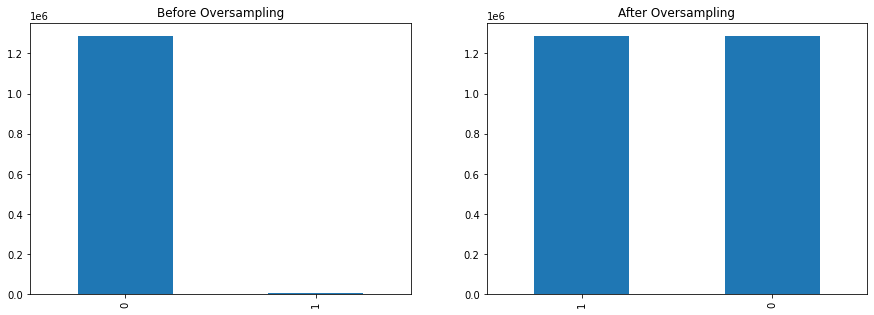

In [79]:
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize =(15, 5))
ax1.set_title('Before Oversampling')
pd.Series(train_X['is_fraud']).value_counts().plot.bar(ax=ax1)

train_X = oversample(train_X)

ax2.set_title('After Oversampling') 
pd.Series(train_X['is_fraud']).value_counts().plot.bar(ax=ax2)
plt.show()

In [80]:
train_y = train_X['is_fraud']
train_X.drop(axis=1, columns=['is_fraud'], inplace=True)

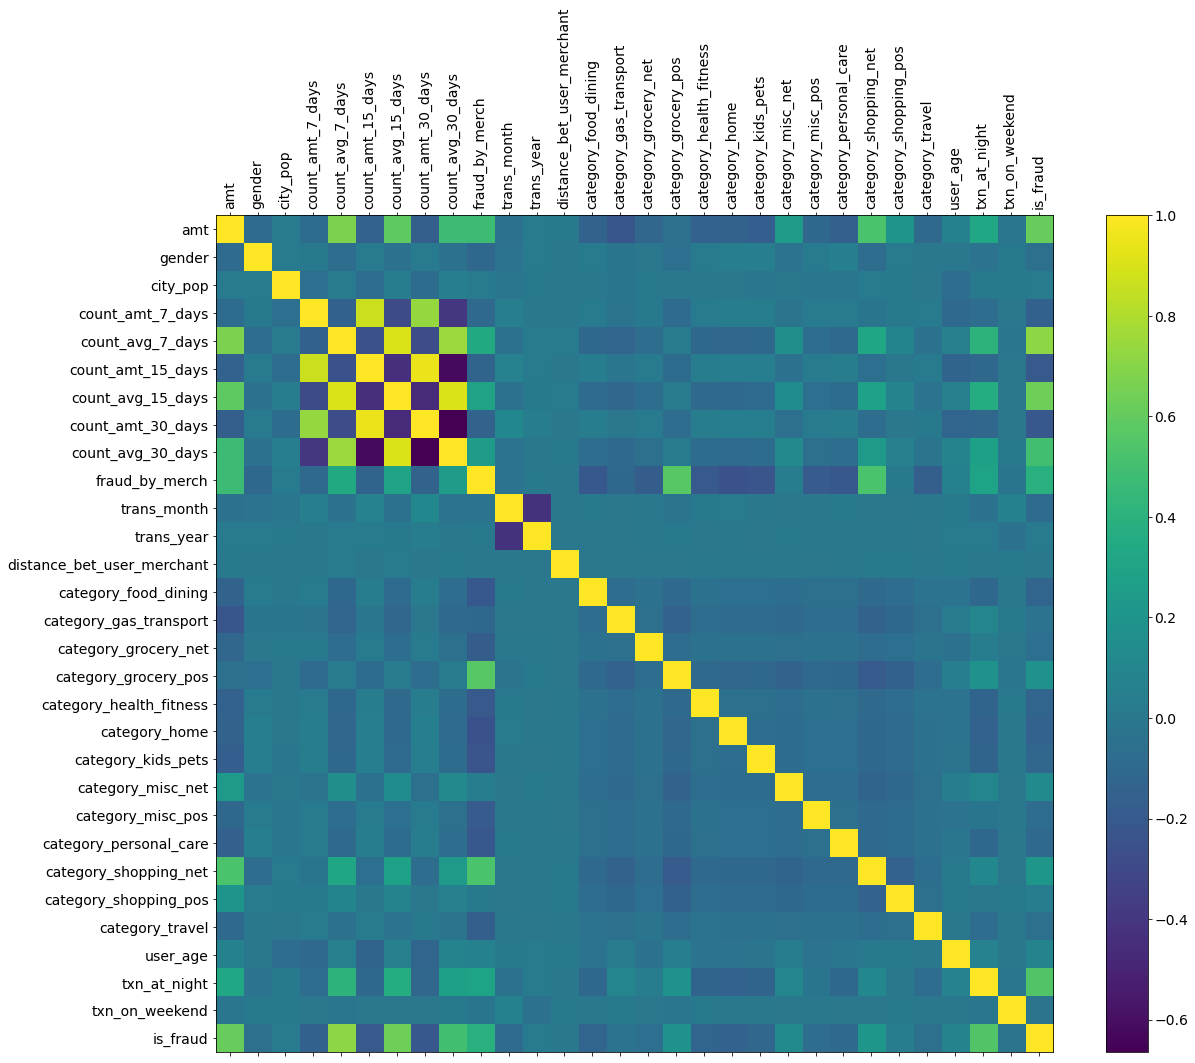

In [107]:
f = plt.figure(figsize=(19, 15))
corr = pd.DataFrame(train_X)
corr['is_fraud']=train_y
plt.matshow(corr.corr(), fignum=f.number)
plt.xticks(range(corr.select_dtypes(['number']).shape[1]), corr.select_dtypes(['number']).columns, fontsize=14, rotation=90)
plt.yticks(range(corr.select_dtypes(['number']).shape[1]), corr.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)


In [48]:
train_X = scale(train_X)

In [49]:
test_X = transform(test_master)

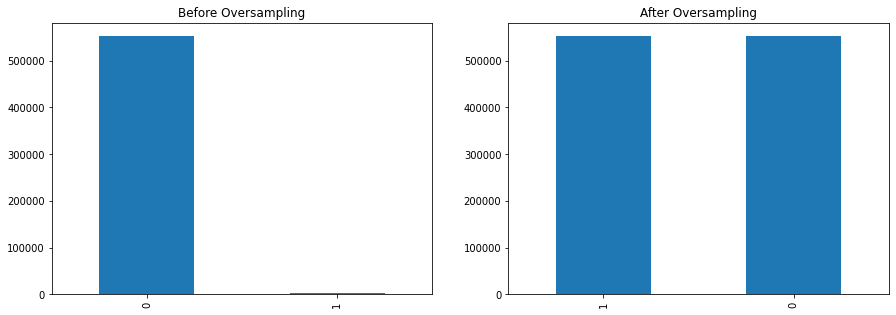

In [50]:
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize =(15, 5))
ax1.set_title('Before Oversampling')
pd.Series(test_X['is_fraud']).value_counts().plot.bar(ax=ax1)

test_X = oversample(test_X)

ax2.set_title('After Oversampling') 
pd.Series(test_X['is_fraud']).value_counts().plot.bar(ax=ax2)
plt.show()

In [51]:
test_y = test_X['is_fraud']
test_X.drop(axis=1, columns=['is_fraud'], inplace=True)

In [52]:
val_X = transform(val_X)

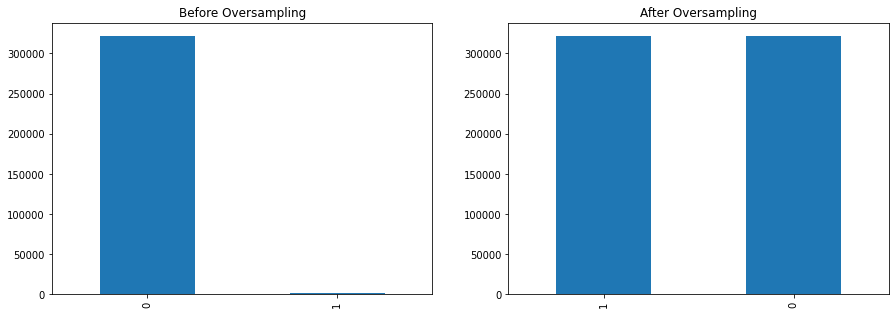

In [53]:
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize =(15, 5))
ax1.set_title('Before Oversampling')
pd.Series(val_X['is_fraud']).value_counts().plot.bar(ax=ax1)

val_X = oversample(val_X)

ax2.set_title('After Oversampling') 
pd.Series(val_X['is_fraud']).value_counts().plot.bar(ax=ax2)
plt.show()

In [54]:
val_y = val_X['is_fraud']
val_X.drop(axis=1, columns=['is_fraud'], inplace=True)

In [55]:
val_X = scale(val_X)

In [56]:
test_X = scale(test_X)

In [57]:
import random
import os
import torch

SEED = 42
def set_default_seed(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

set_default_seed(SEED)
device = torch.cuda.current_device()

In [58]:
x_train = torch.FloatTensor(train_X)
y_train = torch.FloatTensor(train_y)
x_test = torch.FloatTensor(test_X)
y_test = torch.FloatTensor(test_y)
x_val = torch.FloatTensor(val_X)
y_val = torch.FloatTensor(val_y)

In [59]:
class FraudDataset(torch.utils.data.Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, index):
        if self.y is not None:
            return self.x[index].to(device), self.y[index].to(device)
        else:
            return self.x[index].to(device)

In [60]:
train_loader_params = {
    'batch_size': 64,
    'shuffle': True,
    'num_workers': 0
}

test_loader_params = {
    'batch_size': 64,
    'num_workers': 0
}

training_set = FraudDataset(x_train, y_train)
testing_set = FraudDataset(x_test, y_test)
validation_set = FraudDataset(x_val, y_val)

training_generator = torch.utils.data.DataLoader(training_set, **train_loader_params)
testing_generator = torch.utils.data.DataLoader(testing_set, **test_loader_params)
validation_generator = torch.utils.data.DataLoader(validation_set, **test_loader_params)

In [61]:
class FraudDetectionDNN(torch.nn.Module):
  def __init__(self, input_size, hidden_size,p):
    super(FraudDetectionDNN, self).__init__()
    self.input_size = input_size
    self.hidden_size  = hidden_size
    self.p = p
    
    self.fc1 = torch.nn.Linear(self.input_size, 29)
    self.fc2 = torch.nn.Linear(29, 128)
    self.fc3 = torch.nn.Linear(128, 512)
    self.fc4 = torch.nn.Linear(512, 64)
    self.relu = torch.nn.ReLU()
    
    self.fc5 = torch.nn.Linear(64, 1)
    self.sigmoid = torch.nn.Sigmoid()
    self.dropout = torch.nn.Dropout(self.p)
            
  def forward(self, x):
    hidden = self.fc1(x)
    hidden = self.relu(hidden)
    
    hidden = self.dropout(hidden)
    hidden = self.fc2(hidden)
    hidden = self.relu(hidden)
    
    hidden = self.dropout(hidden)
    hidden = self.fc3(hidden)
    hidden = self.relu(hidden)
    
    hidden = self.dropout(hidden)
    hidden = self.fc4(hidden)
    hidden = self.relu(hidden)
    
    hidden = self.dropout(hidden)
    
    output = self.fc5(hidden)
    output = self.sigmoid(output)
    
    return output

In [62]:
model = FraudDetectionDNN(len(x_train[0]), 1000, 0.2).to(device)

In [63]:
model

FraudDetectionDNN(
  (fc1): Linear(in_features=29, out_features=29, bias=True)
  (fc2): Linear(in_features=29, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=512, bias=True)
  (fc4): Linear(in_features=512, out_features=64, bias=True)
  (relu): ReLU()
  (fc5): Linear(in_features=64, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (dropout): Dropout(p=0.2, inplace=False)
)

In [ ]:
criterion = torch.nn.BCELoss().to(device)

In [ ]:
test_X.shape

(1107148, 29)

In [ ]:
train_X.shape

(2578338, 29)

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

def evaluate_model(model,generator,criterion, evaluate_model = False):
    model.eval()
    batch_losses = []
    predictions = []
    labels = []
    for x_batch, y_batch in generator:
        y_pred = model(x_batch)
        predictions.extend(np.round(y_pred.cpu().detach().numpy()))
        labels.extend(y_batch.cpu().detach().numpy().reshape(-1,1))
        loss = criterion(y_pred.squeeze(), y_batch)
        batch_losses.append(loss.item())
    if evaluate_model:
      print(confusion_matrix(predictions, labels))
      print(classification_report(predictions, labels))
    mean_loss = np.mean(batch_losses) 
    return mean_loss

In [ ]:
import time
optimizer = torch.optim.SGD(model.parameters(), lr = 0.07)

n_epochs = 10
model.train()

start_time=time.time()
epochs_train_losses = []
epochs_val_losses = []

for epoch in range(n_epochs):
    model.train()
    train_loss = []
    for x_batch, y_batch in training_generator:
        optimizer.zero_grad()
        y_pred = model(x_batch)
        loss = criterion(y_pred.squeeze(), y_batch)
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())
    
    epochs_train_losses.append(np.mean(train_loss))
    print('Epoch {}: train loss: {}'.format(epoch, np.mean(train_loss)))
    
    val_loss = evaluate_model(model,validation_generator,criterion)    
    epochs_val_losses.append(val_loss)
    print('Validation loss: {}'.format(val_loss))   
    print("")
    
evaluate_model(model, testing_generator, criterion, evaluate_model = False)

Epoch 0: train loss: 0.08528190016841347
Validation loss: 0.09232690334374628

Epoch 1: train loss: 0.05173205808845509
Validation loss: 0.14171657198812335

Epoch 2: train loss: 0.04661769540647773
Validation loss: 0.08067387074517435

Epoch 3: train loss: 0.04440339554913128
Validation loss: 0.0890454876498971

Epoch 4: train loss: 0.041985994845378356
Validation loss: 0.08303874750486626

Epoch 5: train loss: 0.040808953382566536
Validation loss: 0.088457168869759

Epoch 6: train loss: 0.040541037952483344
Validation loss: 0.0816120480165228

Epoch 7: train loss: 0.038604427693887416
Validation loss: 0.08997704252604508

Epoch 8: train loss: 0.03710933127194372
Validation loss: 0.09517149038194835

Epoch 9: train loss: 0.036281914362878434
Validation loss: 0.07953062656923285



0.06743946589902985

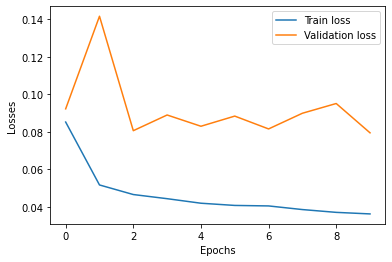

In [ ]:
epochs_range = range(n_epochs)
fig, ax = plt.subplots()
ax.plot(epochs_range, epochs_train_losses)
ax.plot(epochs_range, epochs_val_losses)
ax.set_xlabel("Epochs")
ax.set_ylabel("Losses")
ax.legend(["Train loss", "Validation loss"])

In [ ]:
evaluate_model(model, testing_generator, criterion, evaluate_model = True)

[[544211  10826]
 [  9363 542748]]
              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98    555037
         1.0       0.98      0.98      0.98    552111

    accuracy                           0.98   1107148
   macro avg       0.98      0.98      0.98   1107148
weighted avg       0.98      0.98      0.98   1107148



0.06743946589902985

No handles with labels found to put in legend.


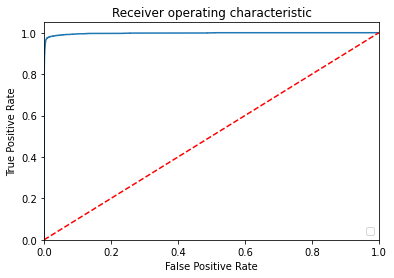

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

def plot_roc_auc(model, X, y):
    roc_auc = roc_auc_score(y, model(torch.FloatTensor(X).cuda()).cpu().detach().numpy())
    fpr, tpr, thresholds = roc_curve(y, model(torch.FloatTensor(X).cuda()).cpu().detach().numpy())
    plt.figure()
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.savefig('Log_ROC')
    plt.show()

plot_roc_auc(model, test_X, test_y)